In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

#Reflect Tables into SQLAlchemy ORM
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [17]:
# create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [32]:
# We can view all of the classes that automap found
Base.classes.keys()
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [33]:
# columns in measurement

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [34]:
# columns in station
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

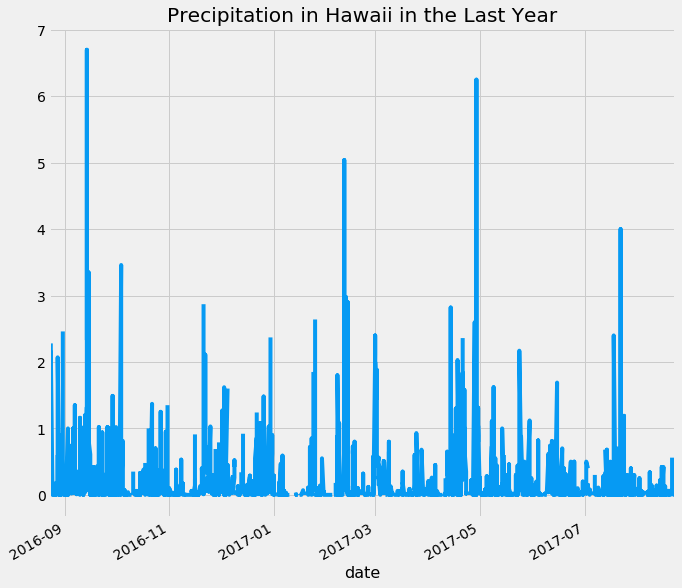

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results\

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
fix_date = dt.datetime.strptime(max_date[0], '%Y-%m-%d')
max_less_one_year = dt.date(fix_date.year -1, fix_date.month, fix_date.day)

# Perform a query to retrieve the data and precipitation scores
columns = [Measurement.date,Measurement.prcp]
query = session.query(*columns).filter(Measurement.date >= max_less_one_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query)

# Sort the dataframe by date
df['date'] = pd.to_datetime(df.date)
df2 = df.set_index('date') 

# Use Pandas Plotting with Matplotlib to plot the data
df2.plot(figsize=(10, 10), sort_columns=True, use_index=True, title='Precipitation in Hawaii in the Last Year', legend=False, color='xkcd:azure')
plt.xlabel('date', fontsize=16)
plt.show()

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [44]:
# Design a query to show how many stations are available in this dataset?
count = session.query(Station.id).count() 
print(f'There are a total of {count} weather stations in Hawaii.')

There are a total of 9 weather stations in Hawaii.


In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

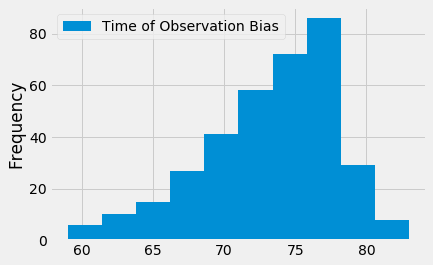

In [48]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = []
high_temp = session.query(Measurement.tobs).\
filter(Measurement.station == "USC00519281").\
filter(Measurement.date >= max_less_one_year)

dft = pd.DataFrame(high_temp, columns=['Time of Observation Bias'])
dft.plot.hist()

In [49]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [50]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
start = "2016-02-01"
end = "2016-02-10"
result = calc_temps(start,end)[0]
result

(56.0, 68.0909090909091, 78.0)

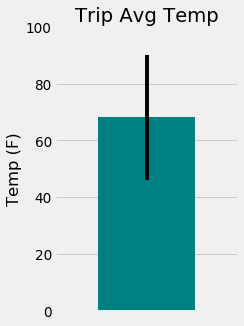

In [64]:
x = [0]
y = [result[1]]
error = [(result[2] - result[0])]

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3, 5), dpi=70)
plt.bar(x,y,color='teal', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [67]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

vacay_start = "2016-02-01"
vacay_end = "2016-02-10"

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
query = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= vacay_start).\
    filter(Measurement.date <= vacay_end).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
df = pd.DataFrame(query, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
df.head()

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.93
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.82
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.78
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.76
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.42
